In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [285]:
!ls

datalab  drive


In [241]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
import keras
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
%matplotlib inline

In [0]:
data_path = 'drive/projects/QuoteGen/data'
if not os.path.exists(data_path):
  os.mkdir(data_path)

In [0]:
models_path = 'drive/projects/QuoteGen/models'
if not os.path.exists(models_path):
  os.mkdir(models_path)

In [0]:
data_txt = os.path.join(data_path, 'quotes.txt')
data_csv = os.path.join(data_path, 'quotes_all.csv')

In [246]:
quotes_ds = []
if os.path.exists(os.path.join(data_path,"quotes_pickle.pkl")):
  with open(os.path.join(data_path,"quotes_pickle.pkl"),'rb') as f:
    quotes_ds = pickle.load(f)
else:
  with open(data_csv) as f:
    for line in f.readlines():
      quotes_ds.append(line.split(";")[0])
  # Pickling the dataset
  if not os.path.exists(os.path.join(data_path,'quotes_pickle.pkl')):
    out = open(os.path.join(data_path,"quotes_pickle.pkl"),'wb')
    pickle.dump(quotes_ds, out)
print("Found %d quotes"%len(quotes_ds))

Found 75966 quotes


In [0]:
def clean_sentences(sentences):
    n_sentences=[]
    temp = ''
    for sentence in sentences:
      temp = "\t "+sentence+ " \n"
      n_sentences.append(temp)
      temp=''
    return n_sentences

In [0]:
cleaned_quotes = clean_sentences(quotes_ds)

In [249]:
cleaned_quotes[0]

"\t Age is an issue of mind over matter. If you don't mind, it doesn't matter. \n"

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [251]:
tokenizer = Tokenizer(lower=True, split=' ', char_level=True)
tokenizer.fit_on_texts(cleaned_quotes)
sequences = tokenizer.texts_to_sequences(cleaned_quotes)

word_index = tokenizer.word_index
print('Found %d unique tokens.' % len(word_index))

Found 83 unique tokens.


In [0]:
index2char = {}
for ch in tokenizer.word_index:
  index2char[tokenizer.word_index.get(ch)] = ch

In [253]:
test = sequences[0]
s = ""
for temp in test:
  if not temp==0:
    s = s+ index2char[temp]
    
cleaned_quotes[0],s

("\t Age is an issue of mind over matter. If you don't mind, it doesn't matter. \n",
 "\t Age is an issue of mind over matter. If you don't mind, it doesn't matter. \n")

In [256]:
quotes_ds[0]

"Age is an issue of mind over matter. If you don't mind, it doesn't matter."

In [0]:
def generate_split(data, lookback= 20, step = 5):
  sentence = []
  next_char = []
  for d in data: 
    for i in range(lookback,len(d), step):
      sentence.append(d[i-lookback:i])
      next_char.append(d[i])
  return sentence, next_char

In [0]:
# Try switching to cleaned_quotes
sentence, next_char = generate_split(quotes_ds)

In [0]:
max_len = 20
n_samples = 120000

x = np.zeros((n_samples, max_len, len(word_index)))
y = np.zeros((n_samples, len(word_index)))

for i,s in enumerate(sentence[:n_samples]):
  for t, char in enumerate(s):
      x[i, t, word_index[char]] = 1
  y[i, word_index[next_char[i]]] = 1

In [0]:
from keras.models import Sequential
from keras import Model
from keras.layers import Input, Embedding, LSTM, Dense, Flatten,Dropout
from keras.optimizers import RMSprop
from keras.models import load_model

In [0]:
model = Sequential()
model.add(LSTM(128, input_shape=(max_len, len(word_index))))
model.add(Dense(len(word_index), activation='softmax'))

In [0]:
optimizer = keras.optimizers.RMSprop(lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
callbacks_list = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.1,
            patience=3,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(models_path,'quotegen.h5'),
            monitor='loss',
            save_best_only=True,
        ),
]

In [0]:
model = load_model(os.path.join(models_path,'quotegen.h5'))

In [296]:
history = model.fit(x, y, batch_size=256, epochs=1, callbacks= callbacks_list)

Epoch 1/1
120000/120000 [==============================] - 30s 250us/step - loss: 0.3572


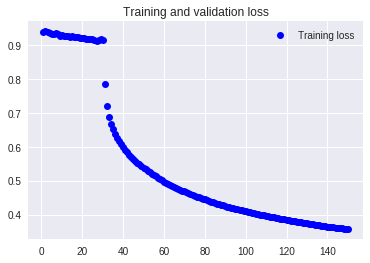

In [286]:
import matplotlib.pyplot as plt
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
def sample(preds, temperature= 0.2):
    preds = np.reshape(preds,preds.shape[-1])
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds+1e-25)/ temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1,preds, 1)
    return np.argmax(probas)

In [0]:
def inference(sent):
  string_length=20
  string_revised=sent.ljust(string_length)
  return string_revised

In [347]:
start_word="when"
inference_text = inference(start_word)

for temperature in [0.1,0.5, 0.7, 1.0, 1.2]:
    print('------ temperature:', temperature)
    sys.stdout.write(inference_text.strip()+" ")
    generated_text = inference_text[:20]+""
    for i in range(50):
      sampled = np.zeros((1, max_len, len(word_index)))
      for t, char in enumerate(generated_text):
          sampled[0, t, word_index[char]] = 1.
      preds = model.predict(sampled, verbose=0)[0]
      next_index = sample(preds, temperature)
      next_char = index2char[next_index]
      generated_text += next_char
      generated_text = generated_text[1:]
      sys.stdout.write(next_char)
    print()

------ temperature: 0.1
when of age. It was a certain age, the way. lefter and 
------ temperature: 0.5
when if the spandentlay isn't the gduest of all this co
------ temperature: 0.7
when of age, dream in the cold one learned he's nothing
------ temperature: 1.0
when edgeAgeness when I would look - to heaps of sure a
------ temperature: 1.2
when isnoung. All re-pleance that came out of - mustine
